In [1]:
""" ciFAIR data loader for tf.keras. Requires tensorflow >= 1.9.

Version: 1.0

https://cvjena.github.io/cifair/
"""

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.data_utils import get_file
from six.moves import cPickle
import numpy as np
import os
import sys


def load_cifair10():
    """Loads [ciFAIR-10 dataset](https://cvjena.github.io/cifair/).

    This is a variant of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
    dataset with a duplicate-free test set.
    See the [ciFAIR homepage](https://cvjena.github.io/cifair/) for more information.

    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

        **x_train, x_test**: uint8 arrays of RGB image data with shape
            `(num_samples, 3, 32, 32)` if `tf.keras.backend.image_data_format()` is
            `'channels_first'`, or `(num_samples, 32, 32, 3)` if the data format
            is `'channels_last'`.

        **y_train, y_test**: uint8 arrays of category labels
            (integers in range 0-9) each with shape (num_samples, 1).
    """
    dirname = 'ciFAIR-10'
    archive_name = 'ciFAIR-10.zip'
    origin = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-10.zip'
    md5_hash = 'ca08fd390f0839693d3fc45c4e49585f'

    path = get_file(archive_name, origin=origin, file_hash=md5_hash, hash_algorithm='md5', extract=True, archive_format='zip')
    path = os.path.join(os.path.dirname(path), dirname)

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
        y_train[(i - 1) * 10000:i * 10000]) = _load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = _load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)


def load_cifair100(label_mode='fine'):
    """Loads [ciFAIR-100 dataset](https://cvjena.github.io/cifair/).

    This is a variant of the [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html)
    dataset with a duplicate-free test set.
    See the [ciFAIR homepage](https://cvjena.github.io/cifair/) for more information.

    Arguments:
        label_mode: one of "fine", "coarse". If it is "fine" the category labels
        are the fine-grained labels, if it is "coarse" the output labels are the
        coarse-grained superclasses.
    
    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

        **x_train, x_test**: uint8 arrays of RGB image data with shape
            `(num_samples, 3, 32, 32)` if `tf.keras.backend.image_data_format()` is
            `'channels_first'`, or `(num_samples, 32, 32, 3)` if the data format
            is `'channels_last'`.

        **y_train, y_test**: uint8 arrays of category labels with shape
            (num_samples, 1).

    Raises:
        ValueError: in case of invalid `label_mode`.
    """
    if label_mode not in ['fine', 'coarse']:
        raise ValueError('`label_mode` must be one of `"fine"`, `"coarse"`.')

    dirname = 'ciFAIR-100'
    archive_name = 'ciFAIR-100.zip'
    origin = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-100.zip'
    md5_hash = 'ddc236ab4b12eeb8b20b952614861a33'

    path = get_file(archive_name, origin=origin, file_hash=md5_hash, hash_algorithm='md5', extract=True, archive_format='zip')
    path = os.path.join(os.path.dirname(path), dirname)

    fpath = os.path.join(path, 'train')
    x_train, y_train = _load_batch(fpath, label_key=label_mode + '_labels')

    fpath = os.path.join(path, 'test')
    x_test, y_test = _load_batch(fpath, label_key=label_mode + '_labels')

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)


def _load_batch(fpath, label_key='labels'):
    """Internal utility for parsing ciFAIR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
            # encode utf8 to ascii
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.encode('utf-8') if isinstance(k, unicode) else k] = v
            d = d_decoded
        else:
            d = cPickle.load(f, encoding='bytes')
            # decode bytes to utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf-8') if isinstance(k, bytes) else k] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


# Imports and function call

In [17]:
from matplotlib import pyplot as plt
import random

#Loads and splits the data
(x_train, y_train), (x_test, y_test) = load_cifair10()



# Display 10x10 random images

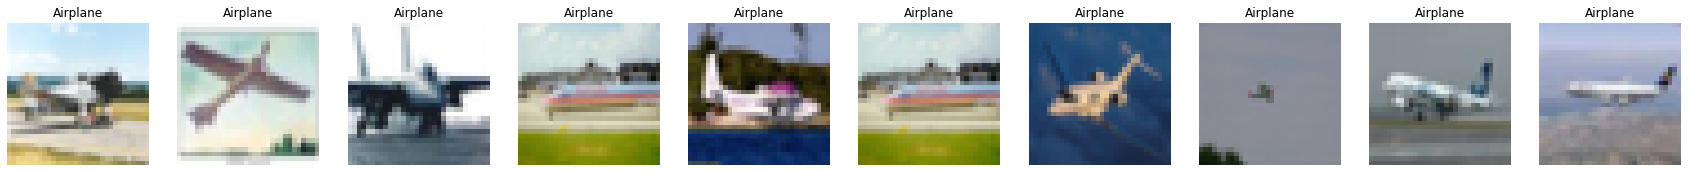

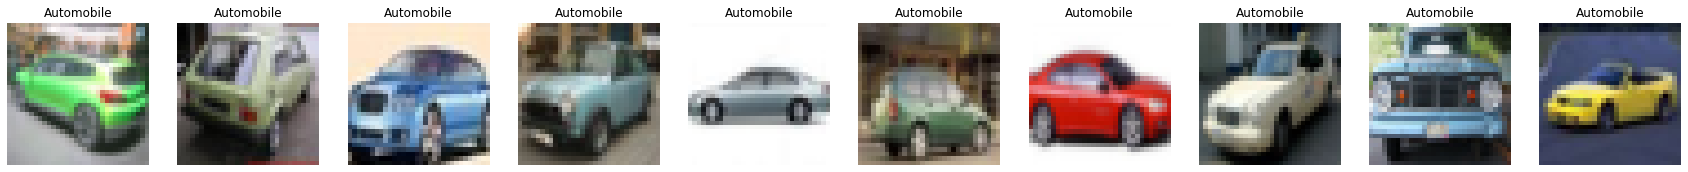

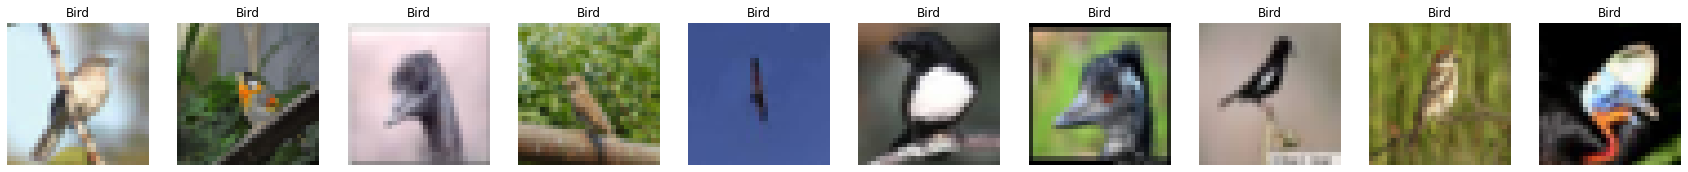

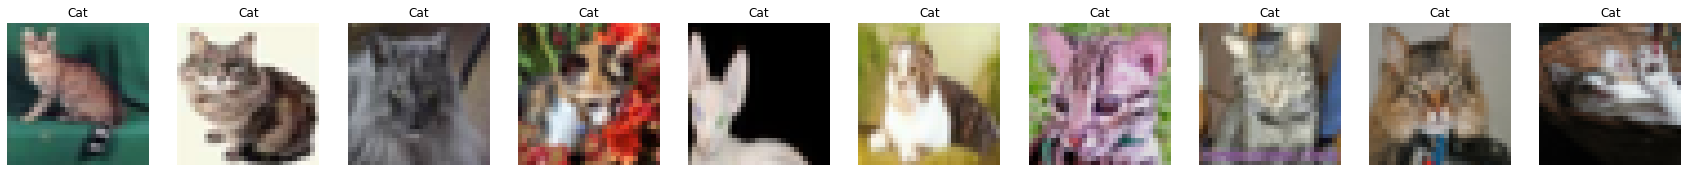

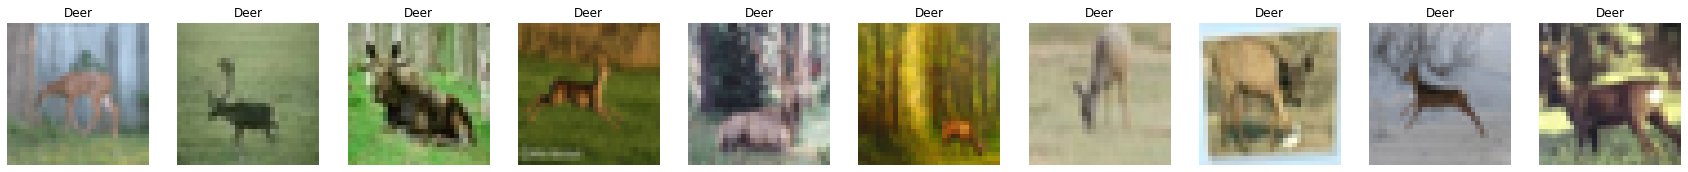

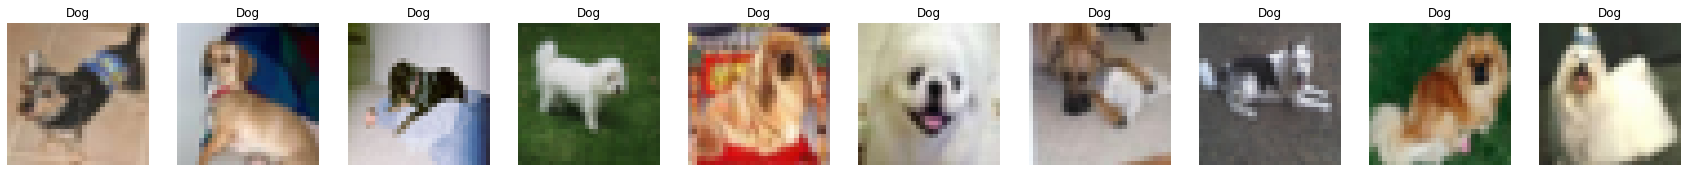

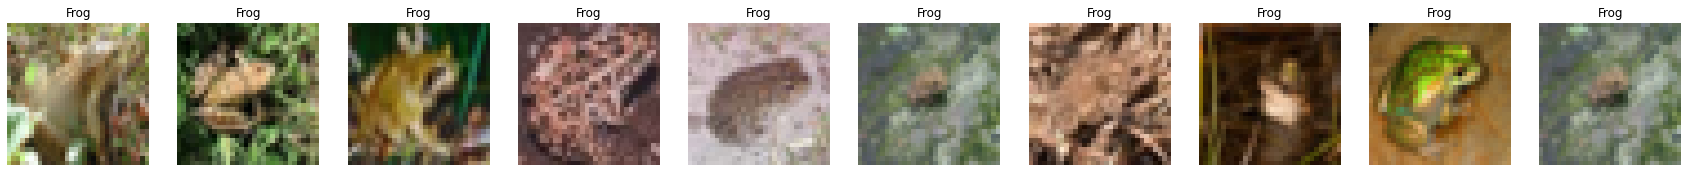

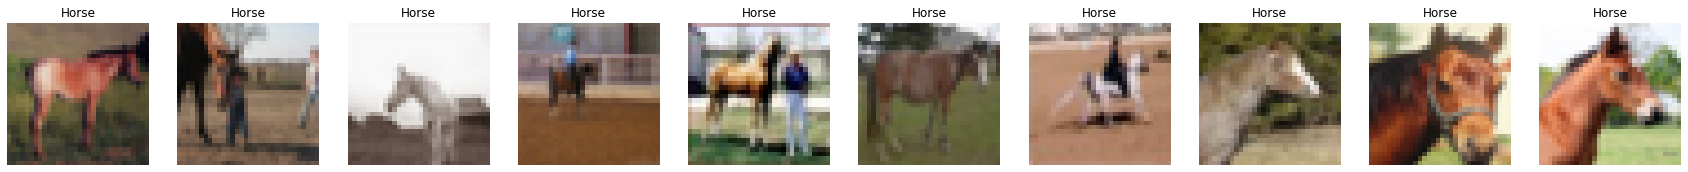

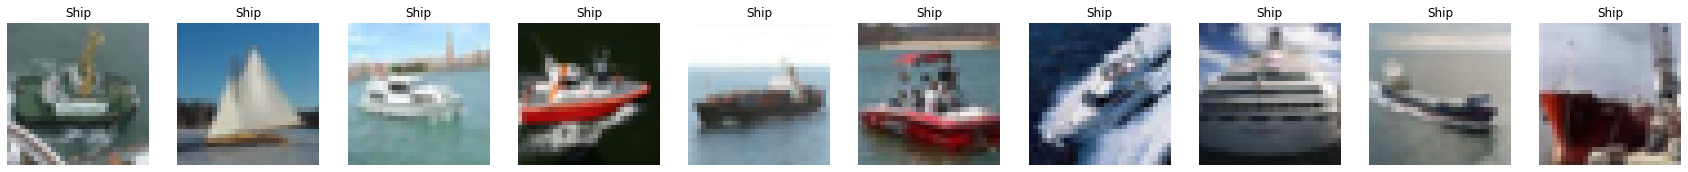

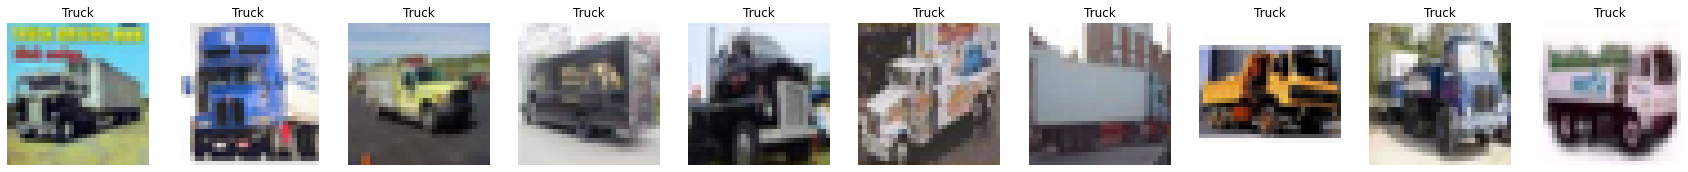

In [65]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
total_classes = 10


#Displays a random 10 airplane images
airplane_count = 0
plt.figure(figsize=(30,30))
while airplane_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'airplane' and airplane_count <= 10):      
      airplane_count = airplane_count + 1
      plt.subplot(1,10, airplane_count)
      plt.imshow(x_test[image_number])
      plt.title("Airplane")
      plt.axis('off')


#Displays a random 10 automobile images
automobile_count = 0

plt.figure(figsize=(30,30))
while automobile_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'automobile' and automobile_count <= 10):      
      automobile_count = automobile_count + 1
      plt.subplot(1,10, automobile_count)
      plt.imshow(x_test[image_number])
      plt.title("Automobile")
      plt.axis('off')


#Displays a random 10 bird images
bird_count = 0

plt.figure(figsize=(30,30))
while bird_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'bird' and bird_count <= 10):      
      bird_count = bird_count + 1
      plt.subplot(1,10, bird_count)
      plt.imshow(x_test[image_number])
      plt.title("Bird")
      plt.axis('off')


#Displays a random 10 cat images
cat_count = 0

plt.figure(figsize=(30,30))
while cat_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'cat' and cat_count <= 10):      
      cat_count = cat_count + 1
      plt.subplot(1,10, cat_count)
      plt.imshow(x_test[image_number])
      plt.title("Cat")
      plt.axis('off')


#Displays a random 10 deer images
deer_count = 0

plt.figure(figsize=(30,30))
while deer_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'deer' and deer_count <= 10):      
      deer_count = deer_count + 1
      plt.subplot(1,10, deer_count)
      plt.imshow(x_test[image_number])
      plt.title("Deer")
      plt.axis('off')


#Displays a random 10 dog images
dog_count = 0

plt.figure(figsize=(30,30))
while dog_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'dog' and dog_count <= 10):      
      dog_count = dog_count + 1
      plt.subplot(1,10, dog_count)
      plt.imshow(x_test[image_number])
      plt.title("Dog")
      plt.axis('off')


#Displays a random 10 frog images
frog_count = 0

plt.figure(figsize=(30,30))
while frog_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'frog' and frog_count <= 10):      
      frog_count = frog_count + 1
      plt.subplot(1,10, frog_count)
      plt.imshow(x_test[image_number])
      plt.title("Frog")
      plt.axis('off')


#Displays a random 10 horse images
horse_count = 0

plt.figure(figsize=(30,30))
while horse_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'horse' and horse_count <= 10):      
      horse_count = horse_count + 1
      plt.subplot(1,10, horse_count)
      plt.imshow(x_test[image_number])
      plt.title("Horse")
      plt.axis('off')


#Displays a random 10 ship images
ship_count = 0

plt.figure(figsize=(30,30))
while ship_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'ship' and ship_count <= 10):      
      ship_count = ship_count + 1
      plt.subplot(1,10, ship_count)
      plt.imshow(x_test[image_number])
      plt.title("Ship")
      plt.axis('off')


#Displays a random 10 truck images
truck_count = 0

plt.figure(figsize=(30,30))
while truck_count < 10:
  image_number = random.randint(1,5000)
  image_label = class_names[int(y_test[image_number])]

  if(image_label == 'truck' and truck_count <= 10):      
      truck_count = truck_count + 1
      plt.subplot(1,10, truck_count)
      plt.imshow(x_test[image_number])
      plt.title("Truck")
      plt.axis('off')

# AlexNet CNN network

In [4]:
import tensorflow as tf
from keras.utils import np_utils

#shapes the data in order to use the neural network
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = np_utils.to_categorical(y_train, total_classes)
y_test = np_utils.to_categorical(y_test, total_classes)

#initialises the model and adds layers
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())

#adds sublayers
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(10))

# Training the network

Epoch 1/10
391/391 [==============================] - 12s 11ms/step - loss: 4.0134 - accuracy: 0.0811 - val_loss: 2.9502 - val_accuracy: 0.0958
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 7.5488 - accuracy: 0.0935 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 8.0252 - accuracy: 0.1003 - val_loss: 8.0590 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 8.0781 - accuracy: 0.0978 - val_loss: 8.0590 - val_accuracy: 0.0980
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 8.0729 - accuracy: 0.0984 - val_loss: 8.0590 - val_accuracy: 0.0999
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 8.0739 - accuracy: 0.0979 - val_loss: 8.0590 - val_accuracy: 0.0999
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 8.0581 - accuracy: 0.0978 - val_loss: 8.0590 - val_accuracy: 0.100

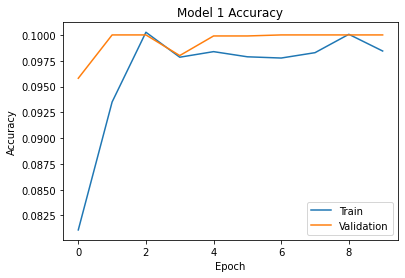

In [5]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#carries out the CNN and plots a graph
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test,y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

The model did not converge how it was meant to so I will refine the model before testing it.

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
391/391 [==============================] - 4s 9ms/step - loss: 1.9864 - accuracy: 0.2653 - val_loss: 144.7256 - val_accuracy: 0.1791
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 1.7656 - accuracy: 0.3499 - val_loss: 55.2074 - val_accuracy: 0.2490
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 1.6948 - accuracy: 0.3819 - val_loss: 60.6507 - val_accuracy: 0.2878
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 1.6736 - accuracy: 0.3966 - val_loss: 81.5984 - val_accuracy: 0.3312
Epoch 5/10
391/391 [==============================] - 3s 8ms/step - loss: 1.6372 - accuracy: 0.4108 - val_loss: 82.0821 - val_accuracy: 0.3098
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 1.6201 - accuracy: 0.4179 - val_loss: 77.7950 - val_accuracy: 0.3396
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 1.5983 - accuracy: 0.4287 - val_loss: 93.9864 - val_accuracy: 0.297

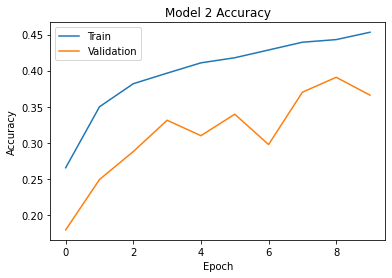

In [6]:
#Normalises the data so the model can converge properly
x_train_norm = x_train/255
x_test_norm = x_test/255


#Repeats what happened above
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Dropout(0.25))
model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(500, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(250, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.25))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

#Added a new optimiser that specifies a learning rate and momentum
optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

#carries out the CNN and plots a graph
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

history = model2.fit(x_train_norm, y_train, batch_size=128, epochs=10, validation_data=(x_test,y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Testing the network

1/1 [==============================] - 0s 114ms/step
This was predicted to be a airplane, and is actually a airplane


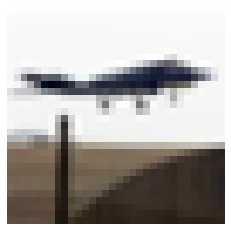

In [7]:
(x_train, y_train), (x_test, y_test) = load_cifair10()

#This generates a random number in the same size as the batches
#Then compares what the model predicted that image to be with what it actually is
#Not guarenteed to be correct
image_number = random.randint(1,391)
plt.imshow(x_test[image_number])
plt.axis('off')

#reshapes so it can access the label of the image
nx = np.array(x_test[image_number])
px = nx.reshape(1, 32, 32, 3)

ny = int(y_test[image_number])

prediction = class_names[model2.predict(px).argmax()]
original = class_names[ny]
print("This was predicted to be a {}, and is actually a {}".format( prediction, original))

# Further changes to improve architecture
Changed optimisation
Doubled epochs

Epoch 1/20
196/196 [==============================] - 3s 15ms/step - loss: 1.7493 - accuracy: 0.3549 - val_loss: 189.4615 - val_accuracy: 0.3994
Epoch 2/20
196/196 [==============================] - 2s 13ms/step - loss: 1.3888 - accuracy: 0.4993 - val_loss: 151.3134 - val_accuracy: 0.4454
Epoch 3/20
196/196 [==============================] - 3s 13ms/step - loss: 1.2547 - accuracy: 0.5521 - val_loss: 185.0336 - val_accuracy: 0.3908
Epoch 4/20
196/196 [==============================] - 3s 13ms/step - loss: 1.1594 - accuracy: 0.5853 - val_loss: 148.7296 - val_accuracy: 0.4649
Epoch 5/20
196/196 [==============================] - 3s 13ms/step - loss: 1.0897 - accuracy: 0.6141 - val_loss: 122.9721 - val_accuracy: 0.4458
Epoch 6/20
196/196 [==============================] - 3s 13ms/step - loss: 1.0392 - accuracy: 0.6298 - val_loss: 118.3389 - val_accuracy: 0.4655
Epoch 7/20
196/196 [==============================] - 3s 13ms/step - loss: 0.9872 - accuracy: 0.6514 - val_loss: 122.4767 - val_ac

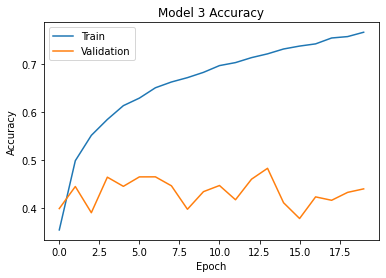

In [8]:
model3 = tf.keras.models.Sequential()
#reload the data

(x_train, y_train), (x_test, y_test) = load_cifair10()

#normalises the new data again
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train_norm = x_train/255
x_test_norm = x_test/255

y_train = np_utils.to_categorical(y_train, total_classes)
y_test = np_utils.to_categorical(y_test, total_classes)

#adds all layers and sublayers
model3.add(tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model3.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model3.add(tf.keras.layers.Dropout(0.25))

model3.add(tf.keras.layers.Flatten())

model3.add(tf.keras.layers.Dense(500, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(250, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.25))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))



model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
#Doubled the amount of epochs, changed the optimzier to adam.
history = model3.fit(x_train_norm, y_train, batch_size=256, epochs=20, validation_data=(x_test,y_test))
#Plot the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

1/1 [==============================] - 0s 61ms/step
This was predicted to be a frog, and is actually a frog


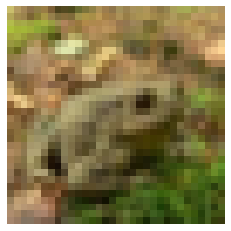

In [9]:
(x_train, y_train), (x_test, y_test) = load_cifair10()

#Same image classifier as before
#Random image, formats data to get the correct label.
#Not guaranteed to be correct when program runs.

image_number = random.randint(1,391)
plt.imshow(x_test[image_number])
plt.axis('off')
nx = np.array(x_test[image_number])
px = nx.reshape(1, 32, 32, 3)

ny = int(y_test[image_number])

prediction = class_names[model3.predict(px).argmax()]
original = class_names[ny]
print("This was predicted to be a {}, and is actually a {}".format( prediction, original))

Added more convolution layers

Epoch 1/20
196/196 [==============================] - 5s 20ms/step - loss: 1.8561 - accuracy: 0.3045 - val_loss: 123.0421 - val_accuracy: 0.4244
Epoch 2/20
196/196 [==============================] - 3s 18ms/step - loss: 1.3628 - accuracy: 0.5034 - val_loss: 97.4527 - val_accuracy: 0.4700
Epoch 3/20
196/196 [==============================] - 4s 18ms/step - loss: 1.1895 - accuracy: 0.5741 - val_loss: 131.7454 - val_accuracy: 0.4715
Epoch 4/20
196/196 [==============================] - 3s 18ms/step - loss: 1.0855 - accuracy: 0.6168 - val_loss: 101.1119 - val_accuracy: 0.4835
Epoch 5/20
196/196 [==============================] - 3s 18ms/step - loss: 1.0063 - accuracy: 0.6471 - val_loss: 96.5856 - val_accuracy: 0.4775
Epoch 6/20
196/196 [==============================] - 4s 23ms/step - loss: 0.9468 - accuracy: 0.6680 - val_loss: 90.0802 - val_accuracy: 0.5143
Epoch 7/20
196/196 [==============================] - 3s 18ms/step - loss: 0.8974 - accuracy: 0.6879 - val_loss: 94.0783 - val_accura

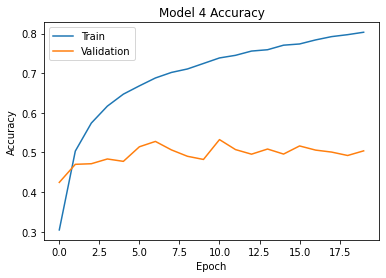

In [10]:
model4 = tf.keras.models.Sequential()
#reload the data

(x_train, y_train), (x_test, y_test) = load_cifair10()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train_norm = x_train/255
x_test_norm = x_test/255

y_train = np_utils.to_categorical(y_train, total_classes)
y_test = np_utils.to_categorical(y_test, total_classes)

model4.add(tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model4.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model4.add(tf.keras.layers.Dropout(0.25))

#Added a new convultion layer
#double the size of the initial layer
model4.add(tf.keras.layers.Conv2D(100, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model4.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model4.add(tf.keras.layers.Dropout(0.25))

model4.add(tf.keras.layers.Flatten())

model4.add(tf.keras.layers.Dense(500, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add(tf.keras.layers.Dense(250, activation='relu'))
model4.add(tf.keras.layers.Dropout(0.25))
#Added a new sub layer
#Less than half of the previous sublayer
model4.add(tf.keras.layers.Dense(100, activation = 'relu'))
model4.add(tf.keras.layers.Dropout(0.1))
model4.add(tf.keras.layers.Dense(10, activation='softmax'))


#recompiles the model to test the new layers
model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model4.fit(x_train_norm, y_train, batch_size=256, epochs=20, validation_data=(x_test,y_test))
#Plot the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Another convolution layer

Epoch 1/20
196/196 [==============================] - 9s 38ms/step - loss: 2.0336 - accuracy: 0.2173 - val_loss: 123.3928 - val_accuracy: 0.2133
Epoch 2/20
196/196 [==============================] - 7s 35ms/step - loss: 1.6055 - accuracy: 0.3979 - val_loss: 112.5606 - val_accuracy: 0.3583
Epoch 3/20
196/196 [==============================] - 7s 36ms/step - loss: 1.4270 - accuracy: 0.4805 - val_loss: 105.3077 - val_accuracy: 0.3918
Epoch 4/20
196/196 [==============================] - 7s 35ms/step - loss: 1.3093 - accuracy: 0.5276 - val_loss: 93.7409 - val_accuracy: 0.3943
Epoch 5/20
196/196 [==============================] - 7s 35ms/step - loss: 1.2446 - accuracy: 0.5574 - val_loss: 90.7782 - val_accuracy: 0.4236
Epoch 6/20
196/196 [==============================] - 7s 36ms/step - loss: 1.1941 - accuracy: 0.5784 - val_loss: 103.4452 - val_accuracy: 0.4057
Epoch 7/20
196/196 [==============================] - 7s 36ms/step - loss: 1.1415 - accuracy: 0.5981 - val_loss: 96.9160 - val_accur

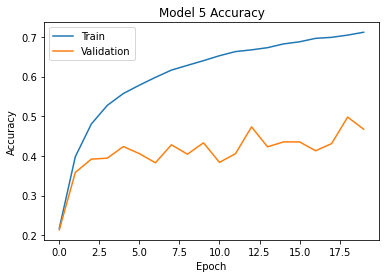

In [13]:
model5 = tf.keras.models.Sequential()
#reload the data

(x_train, y_train), (x_test, y_test) = load_cifair10()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train_norm = x_train/255
x_test_norm = x_test/255

y_train = np_utils.to_categorical(y_train, total_classes)
y_test = np_utils.to_categorical(y_test, total_classes)

#Added a second new convultion layer
#This time it is larger to see the effect that might have on the cnn
model5.add(tf.keras.layers.Conv2D(200, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model5.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model5.add(tf.keras.layers.Dropout(0.25))

model5.add(tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model5.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model5.add(tf.keras.layers.Dropout(0.25))
model5.add(tf.keras.layers.Conv2D(100, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32,32,3)))
model5.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model5.add(tf.keras.layers.Dropout(0.25))




model5.add(tf.keras.layers.Flatten())

model5.add(tf.keras.layers.Dense(500, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.5))
model5.add(tf.keras.layers.Dense(250, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.25))

#Added a second new sub layer
#This time it is larger to see the effect that might have on the cnn
model5.add(tf.keras.layers.Dense(750, activation = 'relu'))
model5.add(tf.keras.layers.Dropout(0.75))

model5.add(tf.keras.layers.Dense(100, activation = 'relu'))
model5.add(tf.keras.layers.Dropout(0.1))

model5.add(tf.keras.layers.Dense(10, activation='softmax'))



model5.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model5.fit(x_train_norm, y_train, batch_size=256, epochs=20, validation_data=(x_test,y_test))
#Plot the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# Standard CNN Architectures - VGGNet

In [11]:
from keras.applications import VGG16

model3 = VGG16(include_top=False, weights=None)
vgg_x_train = model3.predict('x_train_norm')
vgg_x_test = model3.predict('x_test')
vgg_y_train = np_utils.to_categorical(y_train, total_classes)
vgg_y_test = np_utils.to_categorical(y_test, total_classes)

history = model3.fit(vgg_x_train, vgg_y_train, epochs = 20, batch_size = 256, validation_data=(vgg_x_test, vgg_y_test))

#This would have allowed 16 convolution layers
# in theory, would not perform as well as mine based on the outcome
#however, the layers would be more refined than mine.

IndexError: ignored

# Standard CNN Architecture - DenseNet

In [ ]:
denseModel = tf.keras.models.Sequential()
#reload the data

(x_train, y_train), (x_test, y_test) = load_cifair10()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train_norm = x_train/255
x_test_norm = x_test/255

y_train = np_utils.to_categorical(y_train, total_classes)
y_test = np_utils.to_categorical(y_test, total_classes)

def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
 
# add multiple dense blocks together
#have a seperate function for the final block
#allows for referencing across the network so earlier features can still be useful later on
#can achieve good performance with less complexity.